<a href="https://colab.research.google.com/github/KaterinaVat/PINNs/blob/main/pinns_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.optim import Adam

DEVICE = torch.device('cuda' if torch.cuda.is_available() else "cpu")

In [ ]:
class Net(torch.nn.Module):
  def __init__(self, indim = 1, outdim =1):
    super().__init__()
    self.actf = torch.tanh
    self.lin1 = torch.nn.Linear(indim, 100)
    self.lin2 = torch.nn.Linear(100, outdim)

  def forward(self, x):
    x = self.lin1(x)
    x = self.lin2(self.actf(x))
    return x.squeeze()

In [ ]:
class MyData(Dataset):
  def __init__(self, in_tensor, out_tensor):
    self.inp = in_tensor
    self.out = out_tensor

  def __len__(self):
    return len(self.inp)

  def __getitem__(self, idx):
    return self.inp[idx], self.out[idx]

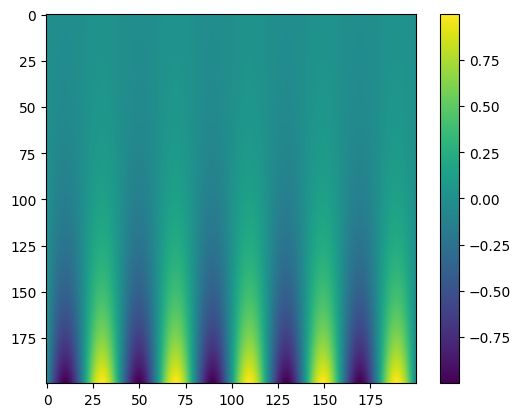

In [ ]:
#generating dataset
def u(x,t):
  return np.exp(-2*np.pi*np.pi*t)*np.sin(np.pi*x)

pts = 200
ts = np.linspace(0.2, 0, pts)
xs = np.linspace(-5, 5, pts)

X,T = np.meshgrid(xs, ts)
U = u(X,T)
plt.imshow(U)
plt.colorbar()

In [ ]:
#формирование датасета для обучения
# флаттен это преобразование структуры в список не содержащий вложенных элементов
train_in = torch.tensor([[x, t] for x, t in zip(X.flatten(), T.flatten())], dtype=torch.float32, requires_grad=True)
train_out = torch.tensor(u(X.flatten(), T.flatten()), dtype = torch.float32)
# u - действительное значение функции
# a = np.array([[1, 2],[3, 4]])
#  array([1, 2, 3, 4])

# перенос обучения на устройство
train_in.to(DEVICE)
train_out.to(DEVICE)

train_dataset = MyData(train_in, train_out)
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle = True)

In [ ]:
model = Net(indim=2, outdim=1).to(DEVICE)
optimizer = Adam(model.parameters(), lr=0.1)
loss_fcn = torch.nn.MSELoss()
epochs = 55

loss_history = []
rel_error_history = []  # Сюда буду сохранять относительные ошибки

for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0

    for batch_in, batch_out in train_dataloader:
        batch_in, batch_out = batch_in.to(DEVICE), batch_out.to(DEVICE)

        optimizer.zero_grad()
        pred = model(batch_in).squeeze()  # Удаляем лишние размерности (если outdim=1)

        loss = loss_fcn(pred, batch_out)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # Усредняем loss по всем батчам
    avg_epoch_loss = epoch_loss / len(train_dataloader)
    loss_history.append(avg_epoch_loss)

    # Вычисляем относительную ошибку на всём датасете
    model.eval()
    total_rel_error = 0.0

    with torch.no_grad():
        for batch_in, batch_out in train_dataloader:
            batch_in, batch_out = batch_in.to(DEVICE), batch_out.to(DEVICE)
            pred = model(batch_in).squeeze()
            true = batch_out

            # Вычисляем относительную ошибку (L2-норма)
            rel_error = torch.norm(pred - true) / torch.norm(true)
            total_rel_error += rel_error.item()

        avg_rel_error = total_rel_error / len(train_dataloader) #усредненная относительная ошибка
        rel_error_history.append(avg_rel_error)

    print(f"Epoch: {epoch+1} | Loss: {avg_epoch_loss:.4f} | Rel. Error: {avg_rel_error:.4f}")

Epoch: 1 | Loss: 0.6026 | Rel. Error: 1.0257
Epoch: 2 | Loss: 0.0706 | Rel. Error: 1.1466
Epoch: 3 | Loss: 0.0870 | Rel. Error: 0.9761
Epoch: 4 | Loss: 0.0764 | Rel. Error: 1.2802
Epoch: 5 | Loss: 0.0750 | Rel. Error: 1.1666
Epoch: 6 | Loss: 0.0754 | Rel. Error: 1.4286
Epoch: 7 | Loss: 0.0741 | Rel. Error: 1.0080
Epoch: 8 | Loss: 0.0696 | Rel. Error: 0.9769
Epoch: 9 | Loss: 0.0637 | Rel. Error: 0.9745
Epoch: 10 | Loss: 0.0615 | Rel. Error: 0.9683
Epoch: 11 | Loss: 0.0588 | Rel. Error: 1.0124
Epoch: 12 | Loss: 0.0556 | Rel. Error: 1.0461
Epoch: 13 | Loss: 0.0509 | Rel. Error: 0.8721
Epoch: 14 | Loss: 0.0487 | Rel. Error: 0.8394
Epoch: 15 | Loss: 0.0448 | Rel. Error: 0.7807
Epoch: 16 | Loss: 0.0401 | Rel. Error: 0.7791
Epoch: 17 | Loss: 0.0358 | Rel. Error: 0.7410
Epoch: 18 | Loss: 0.0320 | Rel. Error: 0.7156
Epoch: 19 | Loss: 0.0255 | Rel. Error: 0.6311
Epoch: 20 | Loss: 0.0211 | Rel. Error: 0.5256
Epoch: 21 | Loss: 0.0178 | Rel. Error: 0.4760
Epoch: 22 | Loss: 0.0159 | Rel. Error: 0.52

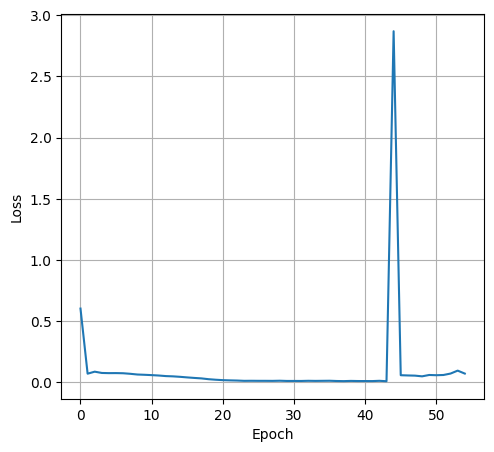

In [ ]:
# График функции потерь
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_history, label="MSE Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

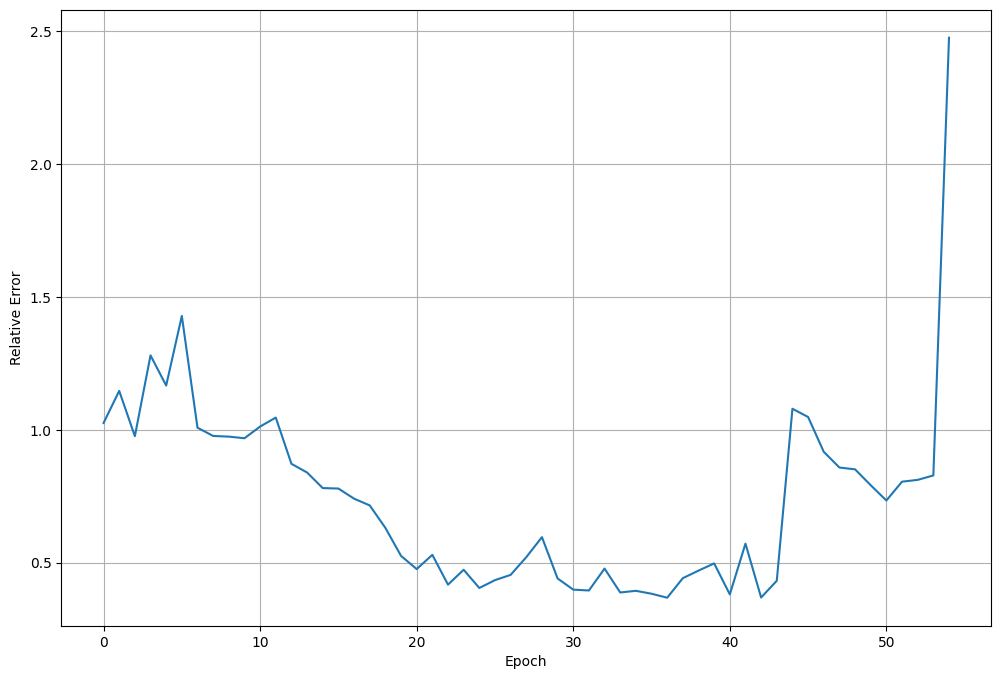

In [ ]:
# График относительной ошибки
plt.figure(figsize=(12,8))
plt.plot(rel_error_history, label="Relative Error (L2)")
plt.xlabel("Epoch")
plt.ylabel("Relative Error")
plt.grid(True)
plt.show()

что даст нам обученная ранее моделька

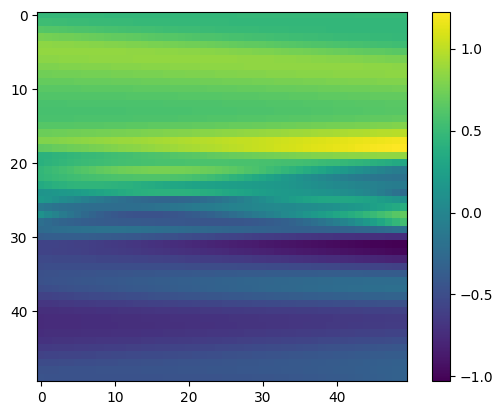

In [ ]:
def u_model(xs, ts):
  pts = torch.tensor(np.array([[x,t] for x,t in zip(xs, ts)]), dtype = torch.float32)
  return model(pts)

pts = 50
ts = np.linspace(0.2, 0, pts)
xs = np.linspace(-5, 5, pts)
X, T = np.meshgrid(xs, ts)
X = X.T
T = T.T

img = []
for x,t in zip(X,T):
  img.append(u_model(x,t).detach().numpy().tolist())
  # детач дает возможность просто сохранить результат а не обучать модель

plt.imshow(img)
plt.colorbar()

начнем пинны

In [ ]:
from torch.autograd import grad
# d²u/dx² = 0.5 * du/dt

def phys_loss(inp, out):
  # inp - переменная по которой берется производные - то есть x и t (нужно чтобы брать градиенты по входам)
  # out - предсказание модели. то, по чему берется прозводные du/dx, du^2/dx^2, du/dt
    dudt = grad(out, inp, grad_outputs=torch.ones_like(out), create_graph=True, allow_unused=True)[0][:,1]
    dudx = grad(out, inp, grad_outputs=torch.ones_like(out), create_graph=True, allow_unused=True)[0][:,0]
    d2udx2 = grad(dudx, inp, grad_outputs=torch.ones_like(dudx), create_graph=True, allow_unused=True)[0][:,0]
    return torch.nn.MSELoss()(d2udx2, 0.5*dudt)

добавление граничных точек
t = 0

In [ ]:
bdry_pts = 200
xs_bdry = np.linspace(-5, 5, bdry_pts)
ts_bdry = np.asarray([0 for x in xs_bdry])

us_bdry = u(xs_bdry, ts_bdry)

train_in_bd = torch.tensor([[x,t] for x, t in zip(xs_bdry, ts_bdry)],  dtype=torch.float32, requires_grad=True)
train_out_bd = torch.tensor(us_bdry, dtype = torch.float32)

train_in_bd.to(DEVICE)
train_out_bd.to(DEVICE)

tensor([-6.1232e-16, -1.5721e-01, -3.1052e-01, -4.5610e-01, -5.9034e-01,
        -7.0989e-01, -8.1179e-01, -8.9350e-01, -9.5299e-01, -9.8877e-01,
        -9.9997e-01, -9.8629e-01, -9.4809e-01, -8.8630e-01, -8.0247e-01,
        -6.9869e-01, -5.7752e-01, -4.4199e-01, -2.9547e-01, -1.4160e-01,
         1.5786e-02,  1.7278e-01,  3.2549e-01,  4.7009e-01,  6.0301e-01,
         7.2092e-01,  8.2091e-01,  9.0048e-01,  9.5765e-01,  9.9101e-01,
         9.9972e-01,  9.8357e-01,  9.4295e-01,  8.7888e-01,  7.9295e-01,
         6.8730e-01,  5.6456e-01,  4.2778e-01,  2.8036e-01,  1.2596e-01,
        -3.1569e-02, -1.8831e-01, -3.4037e-01, -4.8397e-01, -6.1552e-01,
        -7.3177e-01, -8.2982e-01, -9.0723e-01, -9.6208e-01, -9.9300e-01,
        -9.9922e-01, -9.8059e-01, -9.3758e-01, -8.7124e-01, -7.8324e-01,
        -6.7575e-01, -5.5146e-01, -4.1346e-01, -2.6517e-01, -1.1028e-01,
         4.7343e-02,  2.0379e-01,  3.5517e-01,  4.9772e-01,  6.2789e-01,
         7.4244e-01,  8.3853e-01,  9.1376e-01,  9.6

In [ ]:
from torch.autograd import Variable

In [ ]:
model_pinn = Net(indim=2, outdim=1).to(DEVICE)
optimizer_pinn = Adam(model_pinn.parameters(), lr=0.1)
loss_fcn = torch.nn.MSELoss()

# Списки для сохранения ошибок
loss_history = []          # Общий лосс
base_loss_history = []     # Лосс данных
phy_loss_history = []      # Физический лосс
bdry_loss_history = []     # Лосс граничных условий
rel_error_history = []     # Новая: относительная ошибка (L2)

for epoch in range(epochs):
    # Фаза обучения (с батчами)
    model_pinn.train()
    epoch_base_loss, epoch_phy_loss, epoch_bdry_loss = 0, 0, 0

    for batch_in, batch_out in train_dataloader:
        batch_in = batch_in.to(DEVICE).requires_grad_(True)
        batch_out = batch_out.to(DEVICE)

        optimizer_pinn.zero_grad()
        pred = model_pinn(batch_in)

        # Лоссы
        base_loss = loss_fcn(pred, batch_out)
        phy_loss = phys_loss(batch_in, pred)
        bdry_loss = loss_fcn(model_pinn(train_in_bd.to(DEVICE)), train_out_bd.to(DEVICE))

        total_loss = base_loss + phy_loss + bdry_loss
        total_loss.backward()
        optimizer_pinn.step()

        # Накопление лоссов для статистики
        epoch_base_loss += base_loss.item()
        epoch_phy_loss += phy_loss.item()
        epoch_bdry_loss += bdry_loss.item()

    # Усреднение лоссов за эпоху
    avg_base_loss = epoch_base_loss / len(train_dataloader)
    avg_phy_loss = epoch_phy_loss / len(train_dataloader)
    avg_bdry_loss = epoch_bdry_loss / len(train_dataloader)
    total_loss = avg_base_loss + avg_phy_loss + avg_bdry_loss

    # Фаза оценки (относительная ошибка на полном датасете)
    model_pinn.eval()
    with torch.no_grad():
        # Предсказание для всех данных
        train_pred = model_pinn(train_in.to(DEVICE))
        true = train_out.to(DEVICE)

        # Относительная ошибка (L2 норма)
        rel_error = torch.norm(train_pred - true) / torch.norm(true)
        rel_error_history.append(rel_error.item())

    # Сохранение истории
    loss_history.append(total_loss)
    base_loss_history.append(avg_base_loss)
    phy_loss_history.append(avg_phy_loss)
    bdry_loss_history.append(avg_bdry_loss)

    # Вывод информации
    print(f'Epoch: {epoch+1:3d} | Loss: {total_loss:.4f} '
          f'= Data: {avg_base_loss:.4f} '
          f'+ Physics: {avg_phy_loss:.4f} '
          f'+ Boundary: {avg_bdry_loss:.4f} '
          f'| Rel Error: {rel_error.item():.4f}')

Epoch:   1 | Loss: 1.1892 = Data: 0.3862 + Physics: 0.0056 + Boundary: 0.7973 | Rel Error: 1.0297
Epoch:   2 | Loss: 0.5771 = Data: 0.0855 + Physics: 0.0006 + Boundary: 0.4910 | Rel Error: 1.0631
Epoch:   3 | Loss: 0.5638 = Data: 0.0808 + Physics: 0.0008 + Boundary: 0.4822 | Rel Error: 1.3329
Epoch:   4 | Loss: 0.5536 = Data: 0.0781 + Physics: 0.0021 + Boundary: 0.4733 | Rel Error: 1.2562
Epoch:   5 | Loss: 0.5353 = Data: 0.0700 + Physics: 0.0070 + Boundary: 0.4582 | Rel Error: 0.9862
Epoch:   6 | Loss: 0.5293 = Data: 0.0687 + Physics: 0.0097 + Boundary: 0.4510 | Rel Error: 0.9885
Epoch:   7 | Loss: 0.5125 = Data: 0.0646 + Physics: 0.0142 + Boundary: 0.4337 | Rel Error: 1.1744
Epoch:   8 | Loss: 0.5124 = Data: 0.0662 + Physics: 0.0208 + Boundary: 0.4254 | Rel Error: 0.9705
Epoch:   9 | Loss: 0.5032 = Data: 0.0626 + Physics: 0.0242 + Boundary: 0.4163 | Rel Error: 0.9407
Epoch:  10 | Loss: 0.5014 = Data: 0.0622 + Physics: 0.0282 + Boundary: 0.4110 | Rel Error: 0.9544
Epoch:  11 | Loss: 0

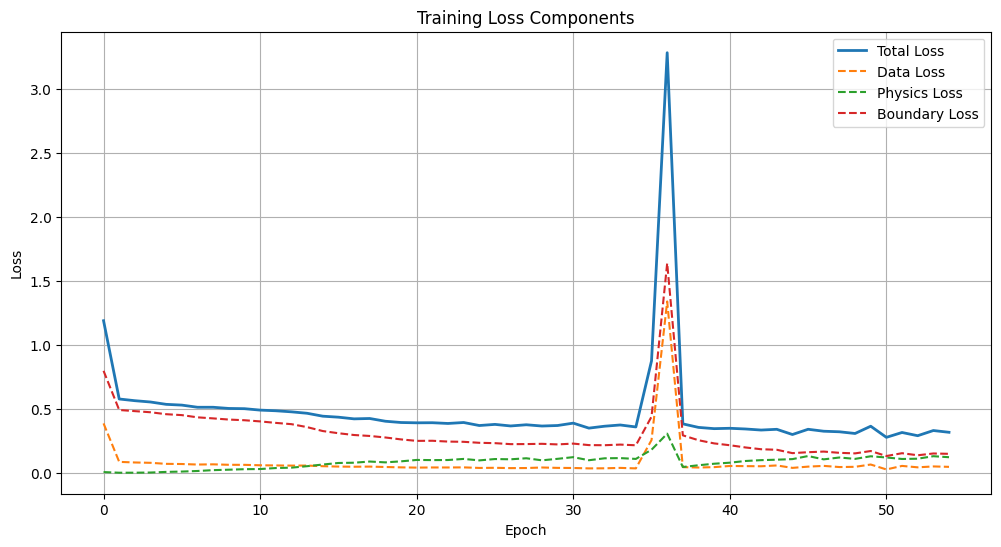

In [ ]:
# Визуализация
plt.figure(figsize=(12, 6))
plt.plot(loss_history, label='Total Loss', linewidth=2)
plt.plot(base_loss_history, label='Data Loss', linestyle='--')
plt.plot(phy_loss_history, label='Physics Loss', linestyle='--')
plt.plot(bdry_loss_history, label='Boundary Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Components')
plt.legend()
plt.grid(True)
plt.show()

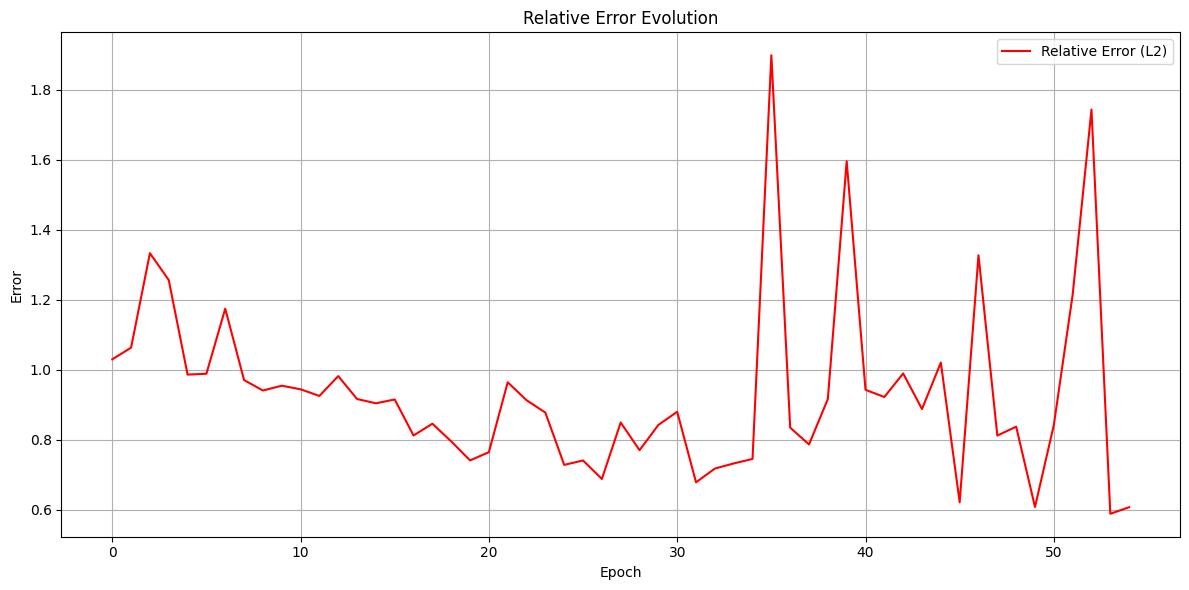

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(rel_error_history, label='Relative Error (L2)', color='red')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Relative Error Evolution')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


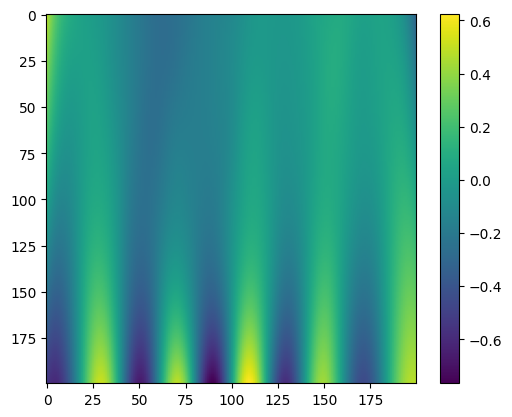

In [ ]:
def u_model_pinn(xs, ts):
    pts = torch.tensor(np.array([[x, t] for x, t in zip(xs, ts)]), dtype=torch.float32)
    return model_pinn(pts)

pts = 200
ts = torch.linspace(0.2, 0, pts)
xs = torch.linspace(-5, 5, pts)

X, T = torch.meshgrid(xs, ts)
X = X.T
T = T.T

img = []
for x, t in zip(X, T):
    img.append(u_model_pinn(x, t).detach().numpy().tolist())

plt.imshow(img)
plt.colorbar()